<a href="https://colab.research.google.com/github/thihanaung-thnn/MLnotebooks/blob/main/02_california_house_best_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the continuation from [this notebook](https://nbviewer.org/github/thihanaung-thnn/MLnotebooks/blob/main/01_california_house_lr_only.ipynb). 

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR 
from sklearn.linear_model import LassoCV, LinearRegression
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import warnings 
warnings.filterwarnings('ignore')

In [2]:
train_data = pd.read_csv('/content/sample_data/california_housing_train.csv')
test_data = pd.read_csv('/content/sample_data/california_housing_test.csv')

In [3]:
sj_coord = [37.3382, -121.8863]
la_coord = [34.0522, -118.2437]
tj_coord = [32.5149, -117.0382]
def calculate_distances(df):
    distances = pd.DataFrame()
    distances['distance_from_sj'] = np.sqrt((df['latitude']-sj_coord[0])**2 + (df['longitude']-sj_coord[1])**2)
    distances['distance_from_la'] = np.sqrt((df['latitude']-la_coord[0])**2 + (df['longitude']-la_coord[1])**2)
    distances['distance_from_tj'] = np.sqrt((df['latitude']-tj_coord[0])**2 + (df['longitude']-tj_coord[1])**2)
    return distances

def log_transform(df):
    log_df = pd.DataFrame()
    columns = ['total_rooms','total_bedrooms', 'population', 'households', 'median_income']
    for col in columns:
        log_df[col] = np.log(df[col])
    return log_df

def feature_engineering(df):
    feature_df = pd.DataFrame()
    feature_df['rooms_per_bedrooms'] = df['total_rooms']/df['total_bedrooms']
    feature_df['rooms_per_pop'] = df['total_rooms']/df['population']
    feature_df['households_per_income'] = df['households']/df['median_income']
    return feature_df

def preprocessing(df):
    distance_df = calculate_distances(df)
    log_df = log_transform(df)
    feature_eng_df = feature_engineering(df)
    combined_df = pd.concat([df, distance_df, log_df, feature_eng_df], axis=1)
    X = combined_df.drop('median_house_value', axis=1)
    y = combined_df['median_house_value']
    return X, y 

In [4]:
X_train_orig, y_train_orig = preprocessing(train_data)
X_test_orig, y_test_orig = preprocessing(test_data)

# Scaling 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_orig)
X_test_scaled = scaler.transform(X_test_orig)

In [80]:
# def stacking_regressors():# just want to test, it will take too long
#     base_regs = []
#     base_regs.append(('cart', DecisionTreeRegressor()))
#     base_regs.append(('svr', SVR()))
#     base_regs.append(('knn', KNeighborsRegressor()))
#     base_regs.append(('lasso', LassoCV()))
#     final_reg = RandomForestRegressor()
#     stack_reg = StackingRegressor(estimators=base_regs, final_estimator=final_reg, cv=5)
#     return stack_reg

def model_list():
    models = {}
    models['SVR'] = SVR()
    models['ElasticNet'] = ElasticNet() # actually elasticnet tends to become Lasso
    models['KNeighbors'] = KNeighborsRegressor()
    models['Random Forest'] = RandomForestRegressor()
    models['Gradient Boosting'] = GradientBoostingRegressor()
    models['Decision Tree'] = DecisionTreeRegressor()
    # models['Stacked Regressor'] = stacking_regressors()
    return models

def model_evaluation(model, X, y):
    kf = RepeatedKFold(n_splits=10, n_repeats=3, random_state=123)
    scores = cross_val_score(model, X, y, scoring='neg_mean_squared_error', n_jobs=-1, cv=kf)
    return scores

In [81]:
# finding best models with default parameters
scores, model_names = [], []
models = model_list()
for name, model in models.items():
    score = model_evaluation(model, X_train_scaled, y_train_orig)
    rmse = np.sqrt(-score)
    model_names.append(name)
    scores.append(rmse)
    print(f'{name}')
    print(f'Mean RMSE : {np.mean(rmse):.2f}')
    print(f'Std RMSE  : {np.std(rmse):.2f}')
    print('-'*20)

SVR
Mean RMSE : 118742.47
Std RMSE  : 2557.30
--------------------
ElasticNet
Mean RMSE : 78367.57
Std RMSE  : 2007.79
--------------------
KNeighbors
Mean RMSE : 61597.63
Std RMSE  : 1745.79
--------------------
Random Forest
Mean RMSE : 46210.76
Std RMSE  : 1438.38
--------------------
Gradient Boosting
Mean RMSE : 52064.82
Std RMSE  : 1563.66
--------------------
Decision Tree
Mean RMSE : 64575.42
Std RMSE  : 2344.90
--------------------
Stacked Regressor
Mean RMSE : 57529.14
Std RMSE  : 1516.00
--------------------


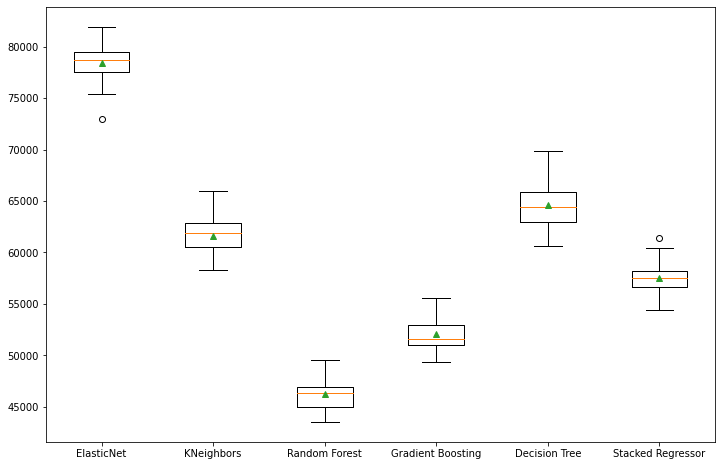

In [85]:
plt.figure(figsize=(12,8))
plt.boxplot(scores[1:], labels=model_names[1:], showmeans=True)
plt.title('Comparing the RMSE scores of different models');

I left the SVR as its errors are high. I think SVR needs hyperparameter tuning. For this dataset, Random Forest may be the best model. 

In [113]:
model = RandomForestRegressor(random_state=123)
grid_params = dict(
    n_estimators=[20, 50, 100, 128], 
    max_depth=[10,15,20, None],
    max_features=[5, 15],
    bootstrap=[True, False]

    )
rf_best = GridSearchCV(model, grid_params, cv=3, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2)
rf_best.fit(X_train_scaled, y_train_orig)

Fitting 3 folds for each of 64 candidates, totalling 192 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=123), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'max_depth': [10, 15, 20, None],
                         'max_features': [5, 15],
                         'n_estimators': [20, 50, 100, 128]},
             scoring='neg_mean_squared_error', verbose=2)

In [125]:
y_pred = rf_best.best_estimator_.predict(X_test_scaled)
errors = abs(y_pred - y_test_orig)
mape = 100 - np.mean(100*(errors/y_test_orig))

print(f'Best Hyperparameters : {rf_best.best_params_}')
print(f'Test data RMSE       : {np.sqrt(mean_squared_error(y_test_orig, y_pred))}')
print(f'Accuracy test data   : {mape:.2f}%')

Best Hyperparameters : {'bootstrap': True, 'max_depth': 15, 'max_features': 15, 'n_estimators': 20}
Test data RMSE       : 48463.0943214638
Accuracy test data   : 83.05%


In [118]:
from sklearn.model_selection import RandomizedSearchCV
model = RandomForestRegressor()
grid_params = dict(
    n_estimators=[int(x) for x in np.linspace(30,200, 4)],
    max_depth=[int(x) for x in np.linspace(5,30,3)],
    max_features=['auto', 'sqrt'],
    min_samples_split=[5,15]
)
rf_random = RandomizedSearchCV(model, grid_params, cv=3, verbose=2,
                               scoring='neg_mean_squared_error', n_jobs=-1)
rf_random.fit(X_train_scaled, y_train_orig)


Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 17, 30],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [5, 15],
                                        'n_estimators': [30, 86, 143, 200]},
                   scoring='neg_mean_squared_error', verbose=2)

In [124]:
y_pred = rf_random.best_estimator_.predict(X_test_scaled)
errors = abs(y_pred - y_test_orig)
mape = 100 - np.mean(100*(errors/y_test_orig))

print(f'Best Hyperparameters : {rf_random.best_params_}')
print(f'Test data RMSE       : {np.sqrt(mean_squared_error(y_test_orig, y_pred))}')
print(f'Accuracy test data   : {mape:.2f}%')

Best Hyperparameters : {'n_estimators': 200, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 5}
Test data RMSE       : 66410.84166730306
Accuracy test data   : 71.70%


In [122]:
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train_orig)

RandomForestRegressor()

In [123]:
y_pred = rf.predict(X_test_scaled)
errors = abs(y_pred - y_test_orig)
mape = 100 - np.mean(100*(errors/y_test_orig))

print(f'Test data RMSE       : {np.sqrt(mean_squared_error(y_test_orig, y_pred))}')
print(f'Accuracy test data   : {mape:.2f}%')

Test data RMSE       : 47466.964997855444
Accuracy test data   : 83.62%


I think the default parameters are the best or may be I need in searching CVs. But there is a great improvement from more than 70000 to 47000-48000 with mean value of 2 lakhs. There may be better models with XGBoost or with Neural Networks. 